In [1]:
import sys
sys.path.insert(1,"../src")
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp 
import matplotlib.pyplot as plt
import random
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
tf.enable_v2_behavior()

import pandas as pd
import tensorflow_addons as tfa

import GA_util
import util as util
import nupack as n
import time

from sklearn.metrics import r2_score
from scipy.stats import spearmanr



print(tf.__version__)

2.11.0


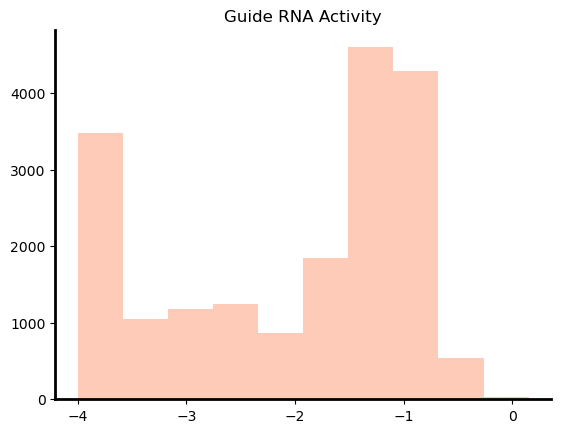

In [12]:
# data = pd.read_csv('../data/CRISPR_data/CCF_merged_pairs_annotated.curated.resampled.tsv',sep='\t')
data = pd.read_csv('../data/CRISPR_data/CCF_merged_pairs_annotated.curated.median.tsv',sep='\t')

# seqs = seqs[seqs['out_logk_measurement'] >-4]

data = data[data['type'] == 'exp']

values = data['out_logk_measurement'].values

plt.figure()
plt.title('Guide RNA Activity')
plt.hist(values,alpha=0.4,color='coral',density=False)
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(2.0)
plt.subplot().spines['bottom'].set_linewidth(2.0)


In [13]:
data.shape

(19124, 9)

In [14]:
#If using resampled version of data to ensure not data leakage
cat_save = []
start = 0
for i in range(data.shape[0]):

    if i %10==0:
        start +=1
        cat_save.append(start)
    else:
        cat_save.append(start)
            
data['category'] = cat_save

/opt/homebrew/Caskroom/miniforge/base/envs/GARDN/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


(array([3825., 1912., 1913., 1912.,    0., 1912., 1913., 1912., 1912.,
        1913.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

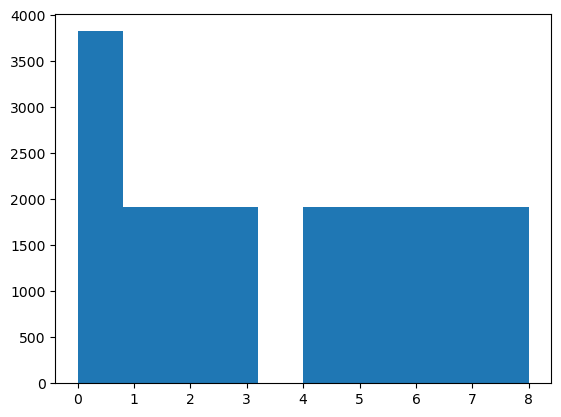

In [15]:
from sklearn.preprocessing import KBinsDiscretizer

est =  KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile')
bins = est.fit(values.reshape(-1,1))
encoded_vals = bins.transform(values.reshape(-1,1))

plt.figure()
plt.hist(encoded_vals)

In [16]:
guides = util.one_hot_encode(pd.DataFrame((data[['guide_seq']])))

guides_extended = np.concatenate((np.zeros(shape=(guides.shape[0],4,20)),
                                  guides,
                                 np.zeros(shape=(guides.shape[0],4,20))),
                                axis=2)

print(guides_extended.shape)

(19124, 4, 68)


In [17]:
targets_before = util.one_hot_encode(pd.DataFrame(data[['target_before']]))
targets_middle = util.one_hot_encode(pd.DataFrame(data[['target_at_guide']]))
targets_after = util.one_hot_encode(pd.DataFrame(data[['target_after']]))




In [18]:
target_seqs = np.concatenate((targets_before[:,:,:],targets_middle,targets_after[:,:,:]),axis=2)
# sandstorm_seqs = util.one_hot_encode(targets)
ppms = GA_util.prototype_ppms_fast(target_seqs)

In [19]:
seqs = np.concatenate((target_seqs,guides_extended),axis=1)
# seqs = target_seqs

print(seqs.shape)

(19124, 8, 68)


In [20]:
from sklearn.model_selection import train_test_split,GroupShuffleSplit
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import random
import keras


# seeds = [1221,4546,9999]
loss = 'mse'
lr = 0.0001
batch_size = 64
epochs = 20
seeds = [1221,4546,999]
folds = 3


joint_r2_save = []
joint_spearman_save = []
joint_mse_save = []

seq_mse_save = []
seq_r2_save = []
seq_spearman_save = []


for i in range(folds):
    

    # seq_train,seq_test,ppm_train,ppm_test,y_train,y_test = train_test_split(seqs,ppms,values,stratify=encoded_vals)
    gss = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=seeds[i])
    
    train_idx,test_idx = next(gss.split(data,groups=data['category']))

    # seq_train,seq_test,ppm_train,ppm_test,y_train,y_test = GroupShuffleSplit(n_split=1,sandstorm_seqs,ppms,values,group_column='category')
    
    seq_train = seqs[train_idx,:,:]
    seq_test = seqs[test_idx,:,:]
    
    ppm_train = ppms[train_idx,:,:]
    ppm_test = ppms[test_idx,:,:]
    
    y_train = values[train_idx]
    y_test = values[test_idx]

    print(seq_train.shape)
    print(seq_test.shape)

    joint_model = GA_util.create_SANDSTORM_cas(seq_len=seqs.shape[2],ppm_len=ppms.shape[2],latent_dim=64,internal_activation='relu',output_activation='linear')
    print(joint_model.summary())

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    joint_model.compile(loss=loss,optimizer=optimizer)
    
# es = tfk.callbacks.EarlyStopping(monitor='val_loss',
#             mode='min', patience=10,restore_best_weights=True)


    print("TRAINING SANDSTORM")
    hist = joint_model.fit([seq_train,ppm_train],y_train,
                           validation_data=[[seq_test,ppm_test],y_test],
                           epochs=epochs,
                           batch_size=batch_size)    



    y_preds = joint_model.predict([seq_test,ppm_test])
    joint_mse =hist.history['val_loss'][-1]
    joint_r2 = r2_score(y_test,y_preds)
    joint_spearman = spearmanr(y_test,y_preds)[0]
    
    joint_mse_save.append(joint_mse)
    joint_r2_save.append(joint_r2)
    joint_spearman_save.append(joint_spearman)
    print(r2_score(y_test,y_preds))


(15294, 8, 68)
(3830, 8, 68)
Metal device set to: Apple M1 Ultra


2025-03-18 18:47:24.437079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-18 18:47:24.437102: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "joint_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 68, 68, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 1, 68, 16)    1312        ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 8, 68, 1)]   0           []                               
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 1, 68, 16)   0           ['conv2d_3[0][0]']               
 out2D)                                                                                 

2025-03-18 18:47:25.536985: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-18 18:47:25.908340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - ETA: 0s - loss: 2.3050

2025-03-18 18:47:33.795664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 9s 14ms/step - loss: 2.3050 - val_loss: 2.3020
Epoch 2/20
239/239 [==============================] - 2s 9ms/step - loss: 1.1618 - val_loss: 1.3430
Epoch 3/20
239/239 [==============================] - 2s 9ms/step - loss: 1.0757 - val_loss: 1.1786
Epoch 4/20
239/239 [==============================] - 2s 9ms/step - loss: 1.0154 - val_loss: 0.9863
Epoch 5/20
239/239 [==============================] - 2s 9ms/step - loss: 0.9475 - val_loss: 0.9737
Epoch 6/20
239/239 [==============================] - 2s 9ms/step - loss: 0.8412 - val_loss: 0.8735
Epoch 7/20
239/239 [==============================] - 2s 8ms/step - loss: 0.6883 - val_loss: 0.6485
Epoch 8/20
239/239 [==============================] - 2s 9ms/step - loss: 0.5714 - val_loss: 0.5789
Epoch 9/20
239/239 [==============================] - 2s 8ms/step - loss: 0.5284 - val_loss: 0.5470
Epoch 10/20
239/239 [==============================] - 2s 9ms/step - loss: 0.5036 - val_loss: 0.5345
Epoch 11/

2025-03-18 18:48:13.989326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 0s 3ms/step
0.643468557397337
(15294, 8, 68)
(3830, 8, 68)
Model: "joint_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 68, 68, 1)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 1, 68, 16)    1312        ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 8, 68, 1)]   0           []                               
                                                                                                  
 spatial_dropout2d_1 (SpatialDr  (None, 1, 68, 16)   0           ['conv2d_9[0][0]']  

2025-03-18 18:48:14.983989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - ETA: 0s - loss: 2.1991

2025-03-18 18:48:17.376136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 3s 10ms/step - loss: 2.1991 - val_loss: 2.5786
Epoch 2/20
239/239 [==============================] - 2s 9ms/step - loss: 1.1532 - val_loss: 1.4154
Epoch 3/20
239/239 [==============================] - 2s 9ms/step - loss: 1.0664 - val_loss: 1.0459
Epoch 4/20
239/239 [==============================] - 2s 9ms/step - loss: 0.9859 - val_loss: 0.9438
Epoch 5/20
239/239 [==============================] - 2s 9ms/step - loss: 0.8722 - val_loss: 0.8924
Epoch 6/20
239/239 [==============================] - 2s 9ms/step - loss: 0.7109 - val_loss: 0.7294
Epoch 7/20
239/239 [==============================] - 2s 9ms/step - loss: 0.6207 - val_loss: 0.5926
Epoch 8/20
239/239 [==============================] - 2s 9ms/step - loss: 0.5760 - val_loss: 0.5687
Epoch 9/20
239/239 [==============================] - 2s 9ms/step - loss: 0.5457 - val_loss: 0.5442
Epoch 10/20
239/239 [==============================] - 2s 9ms/step - loss: 0.5251 - val_loss: 0.5368
Epoch 11/

2025-03-18 18:48:57.889197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 0s 3ms/step
0.6523424030738953
(15294, 8, 68)
(3830, 8, 68)
Model: "joint_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 68, 68, 1)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 1, 68, 16)    1312        ['input_6[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 8, 68, 1)]   0           []                               
                                                                                                  
 spatial_dropout2d_2 (SpatialDr  (None, 1, 68, 16)   0           ['conv2d_15[0][0]']

2025-03-18 18:48:58.866097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - ETA: 0s - loss: 2.8547

2025-03-18 18:49:01.269917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 3s 10ms/step - loss: 2.8547 - val_loss: 2.5404
Epoch 2/20
239/239 [==============================] - 2s 8ms/step - loss: 1.1945 - val_loss: 1.4520
Epoch 3/20
239/239 [==============================] - 2s 9ms/step - loss: 1.1081 - val_loss: 1.1413
Epoch 4/20
239/239 [==============================] - 2s 10ms/step - loss: 1.0334 - val_loss: 1.0462
Epoch 5/20
239/239 [==============================] - 2s 9ms/step - loss: 0.9481 - val_loss: 0.9671
Epoch 6/20
239/239 [==============================] - 2s 10ms/step - loss: 0.8116 - val_loss: 0.8667
Epoch 7/20
239/239 [==============================] - 2s 9ms/step - loss: 0.6352 - val_loss: 0.6789
Epoch 8/20
239/239 [==============================] - 2s 9ms/step - loss: 0.5571 - val_loss: 0.5832
Epoch 9/20
239/239 [==============================] - 2s 9ms/step - loss: 0.5299 - val_loss: 0.5752
Epoch 10/20
239/239 [==============================] - 2s 9ms/step - loss: 0.5116 - val_loss: 0.5553
Epoch 1

2025-03-18 18:49:44.661692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 1s 3ms/step
0.6416040985750213


In [21]:
from collections import defaultdict
import gzip
import os


class Cas13ActivityParser:
    """Parse data from paired crRNA/target Cas13 data tested with CARMEN.
    The output is numeric values (for regression) rather than labels.
    """
    INPUT_TSV_RESAMPLED = '../data/CRISPR_data/CCF_merged_pairs_annotated.curated.resampled.tsv.gz'
    INPUT_TSV_MEDIAN = '../data/CRISPR_data/CCF_merged_pairs_annotated.curated.median.tsv.gz'

    # Define crRNA (guide) length; used for determining range of crRNA
    # in nucleotide space
    CRRNA_LEN = 28

    # Define the seed region; for Cas13a, the middle ~third of the spacer
    SEED_START = int(CRRNA_LEN * 1/3) # 0-based, inclusive
    SEED_END = int(CRRNA_LEN * 2/3) + 1 # 0-based, exclusive

    # Define threshold on activity for inactive/active data points
    ACTIVITY_THRESHOLD = -4.0

    def __init__(self, subset=None, context_nt=10, split=(0.8, 0.1, 0.1),
            shuffle_seed=1, stratify_randomly=False, stratify_by_pos=False,
            use_median_measurement=False):
        """
        Args:
            subset: either 'exp' (use only experimental data points, which
                generally have a mismatch between guide/target), 'pos' (use
                only data points corresponding to a positive guide/target
                match with no mismatches (i.e., the wildtype target)),
                'neg' (use only data points corresponding to negative guide/
                target (i.e., high divergence between the two)), or
                'exp-and-pos;; if 'None', use all data points
            context_nt: nt of target sequence context to include alongside
                each guide
            split: (train, validation, test) split; must sum to 1.0
            shuffle_seed: seed to use for the random module to shuffle
            stratify_randomly: if set, shuffle rows before splitting into
                train/validate/test
            stratify_by_pos: if set, consider the position along the target
                and split based on this
            use_median_measurement: if True, use median of replicate measurements;
                otherwise, use resampled values
        """
        assert subset in (None, 'exp', 'pos', 'neg', 'exp-and-pos')
        self.subset = subset

        self.context_nt = context_nt

        assert sum(split) == 1.0
        self.split_train, self.split_validate, self.split_test = split

        if stratify_randomly and stratify_by_pos:
            raise ValueError("Cannot set by stratify_randomly and stratify_by_pos")
        self.stratify_randomly = stratify_randomly
        self.stratify_by_pos = stratify_by_pos

        random.seed(shuffle_seed)

        self.classify_activity = False
        self.regress_on_all = False
        self.regress_only_on_active = False

        self.make_feats_for_baseline = None

        self.normalize_crrna_activity = False
        self.use_difference_from_wildtype_activity = False

        self.was_read = False

        if use_median_measurement:
            self.INPUT_TSV = self.INPUT_TSV_MEDIAN
        else:
            self.INPUT_TSV = self.INPUT_TSV_RESAMPLED

    def set_activity_mode(self, classify_activity, regress_on_all,
            regress_only_on_active):
        """Set mode for which points to read regarding their activity.
        Args:
            classify_activity: if True, have the output variable be a label
                (False/True) regarding activity of a guide/target pair
            regress_on_all: if True, output all guide/target pairs
            regress_only_on_active: if True, only output guide/target pairs
                corresponding to high activity
        """
        num_set = (int(classify_activity) + int(regress_on_all) +
                int(regress_only_on_active))
        if num_set != 1:
            raise Exception(("Exactly one of 'classify_activity' and "
                "'regress_on_all' and 'regress_only_on_active' can be set"))
        self.classify_activity = classify_activity
        self.regress_on_all = regress_on_all
        self.regress_only_on_active = regress_only_on_active

    def set_make_feats_for_baseline(self, feats):
        """Generate input features specifically for the baseline model.
        Args:
            feats: one of 'onehot-flat' (one-hot encoding, flattened to 1D);
                'onehot-simple' (one-hot encoding that encodes the target
                sequence and mismatches between the guide and it, leaving the
                guide encoding as all 0 when matching); 'handcrafted'
                (nucleotide frequency, dinucleotide frequency, etc.); or
                'combined' (concatenated 'onehot-simple' and 'handcrafted')
        """
        self.make_feats_for_baseline = feats

    def set_normalize_crrna_activity(self):
        """Normalize activity of each crRNA, across targets, to have mean 0 and
        stdev 1.
        We can only set one of 'normalize_crrna_activity' and
        'use_difference_from_wildtype_activity'.
        """
        assert self.use_difference_from_wildtype_activity is False
        self.normalize_crrna_activity = True

    def set_use_difference_from_wildtype_activity(self):
        """Use, as the activity value for a pair of guide g and target t, the
        difference between the g-t activity and the mean activity between g and
        its wildtype (matching) targets.
        We can only set one of 'normalize_crrna_activity' and
        'use_difference_from_wildtype_activity'.
        """
        assert self.normalize_crrna_activity is False
        self.use_difference_from_wildtype_activity = True

    def _gen_input_and_output(self, row):
        """Generate input features and output for each row.
        This generates a one-hot encoding for each sequence. Because we have
        the target ('target_at_guide') and guide sequence ('guide_seq'),
        we must encode how they compare to each other. Here, for each nucleotide
        position, we use an 8-bit vector (4 to encode the target sequence and
        4 for the guide sequence). For example, 'A' in the target and 'G' in the
        guide will be [1,0,0,0,0,0,1,0] for [A,C,G,T] one-hot encoding. There are
        other ways to do this as well: e.g., a 4-bit vector that represents an OR
        between the one-hot encoding of the target and guide (e.g., 'A' in the
        target and 'G' in the guide would be [1,0,1,0]), but this does not
        distinguish between bases in the target and guide (i.e., the encoding
        is the same for 'G' in the target and 'A' in the guide) which might
        be important here.
        Note that when self.make_feats_for_baseline is set, the input feature
        vector is different, depending on its value.
        Args:
            row: dict representing row of data (key'd by column
                name)
        Returns:
            tuple (i, out) where i is a one-hot encoding of the input
            and out is an output value (or out is in the format specified by
            self.make_feats_for_baseline)
        """
        # Check self.make_feats_for_baseline
        assert self.make_feats_for_baseline in [None, 'onehot-flat',
            'onehot-simple', 'handcrafted', 'combined']

        onehot_idx = {'A': 0, 'G': 1, 'C': 2, 'T': 3}
        onehot_order = ('A', 'G', 'C', 'T')
        def onehot(b):
            # One-hot encoding of base b
            assert b in onehot_idx.keys()
            v = [0, 0, 0, 0]
            v[onehot_idx[b]] = 1
            return v

        # For the baseline, keep a short string description of the
        # feature at each index
        if self.make_feats_for_baseline in ['onehot-flat', 'onehot-simple',
                'handcrafted', 'combined']:
            self.baseline_descriptions = []
        else:
            self.baseline_descriptions = None
        def descriptions_for_onehot(s):
            # List of descriptions for each base
            return [s + '-' + b for b in onehot_order]

        # Create the input features for target sequence context on
        # the end before the guide
        input_feats_context_before = []
        context_before = row['target_before']
        assert self.context_nt <= len(context_before)
        start = len(context_before) - self.context_nt
        for pos in range(start, len(context_before)):
            # Make a one-hot encoding for this position of the target sequence
            v = onehot(context_before[pos])
            if self.make_feats_for_baseline is None:
                # For the 4 bits of guide sequence, use [0,0,0,0] (there is
                # no guide at this position)
                v += [0, 0, 0, 0]
                input_feats_context_before += [v]
            elif self.make_feats_for_baseline in ['onehot-flat',
                    'onehot-simple', 'combined']:
                # For the baseline, only use a one-hot encoding of the
                # target (and in a 1D array)
                input_feats_context_before += v
                self.baseline_descriptions += descriptions_for_onehot(
                        'target-before-'+str(pos))
            elif self.make_feats_for_baseline == 'handcrafted':
                # No feature for the baseline here
                pass
            else:
                raise ValueError("Unknown choice of make_feats_for_baseline")

        # Create the input features for target and guide sequence
        input_feats_guide = []
        target = row['target_at_guide']
        guide = row['guide_seq']
        baseline_mismatches_pos = []
        assert len(target) == len(guide)
        for pos in range(len(guide)):
            # Make a one-hot encoding (4 bits) for each of the target
            # and the guide
            v_target = onehot(target[pos])
            v_guide = onehot(guide[pos])
            if self.make_feats_for_baseline is None:
                # Combine them into an 8-bit vector
                v = v_target + v_guide
                input_feats_guide += [v]
            elif self.make_feats_for_baseline == 'onehot-flat':
                # For the baseline, use an 8-bit vector (flattened - i.e.,
                # concatenated with the other positions)
                v = v_target + v_guide
                input_feats_guide += v
                self.baseline_descriptions += descriptions_for_onehot(
                        'target-at-guide-'+str(pos))
                self.baseline_descriptions += descriptions_for_onehot(
                        'guide-seq-'+str(pos))
            elif self.make_feats_for_baseline in ['onehot-simple', 'combined']:
                # For the baseline, use a one-hot encoding of the target
                # (in a 1D array) and then use a one-hot encoding that gives
                # whether there is a mismatch and, if so, what the guide
                # base is
                if target[pos] == guide[pos]:
                    # No mismatch; use 0,0,0,0 for the guide
                    input_feats_guide += v_target + [0, 0, 0, 0]
                else:
                    # Mismatch; have the guide indicate which base there is
                    input_feats_guide += v_target + v_guide
                    baseline_mismatches_pos += [pos]
                self.baseline_descriptions += descriptions_for_onehot(
                        'target-at-guide-'+str(pos))
                self.baseline_descriptions += descriptions_for_onehot(
                        'guide-mismatch-allele-'+str(pos))
            elif self.make_feats_for_baseline == 'handcrafted':
                # Mark number of mismatches, but do not use input_feats_guide
                if target[pos] != guide[pos]:
                    baseline_mismatches_pos += [pos]
            else:
                raise ValueError("Unknown choice of make_feats_for_baseline")
    
        # Create the input features for target sequence context on
        # the end after the guide
        input_feats_context_after = []
        context_after = row['target_after']
        assert self.context_nt <= len(context_after)
        for pos in range(self.context_nt):
            # Make a one-hot encoding for this position of the target sequence
            v = onehot(context_after[pos])
            if self.make_feats_for_baseline is None:
                # For the 4 bits of guide sequence, use [0,0,0,0] (there is
                # no guide at this position)
                v += [0, 0, 0, 0]
                input_feats_context_after += [v]
            elif self.make_feats_for_baseline in ['onehot-flat',
                    'onehot-simple', 'combined']:
                # For the baseline, only use a one-hot encoding of the
                # target (and in a 1D array)
                if self.make_feats_for_baseline == 'combined' and pos in [0, 1]:
                    # We add a PFS feature, with 2 nt, below; so do not
                    # add features here (this would just decouple the 2 nt in
                    # that feature)
                    pass
                else:
                    input_feats_context_after += v
                    self.baseline_descriptions += descriptions_for_onehot(
                            'target-after-'+str(pos))
            elif self.make_feats_for_baseline == 'handcrafted':
                # No feature for the baseline here
                pass
            else:
                raise ValueError("Unknown choice of make_feats_for_baseline")

        # Combine the input features
        input_feats = input_feats_context_before + input_feats_guide + input_feats_context_after
        if self.make_feats_for_baseline == 'handcrafted':
            # The features directly from sequence should not have been set
            assert len(input_feats) == 0
        if self.make_feats_for_baseline in ['handcrafted', 'combined']:
            # Have the feature vector for the baseline include additional
            # features: position-independent nucleotide frequency, dinucleotide
            # frequency, and GC content (all in the guide); and number of
            # mismatches between guide and target
            bases = ('A', 'G', 'C', 'T')
            for b in bases:
                # Add a feature giving nucleotide frequency (count) of b in
                # the guide
                input_feats += [guide.count(b)]
                self.baseline_descriptions += ['nucleotide-count-'+b]
            for b1 in bases:
                for b2 in bases:
                    # Add a feature giving dinucleotide frequency (count) of
                    # b1+b2 in the guide
                    input_feats += [guide.count(b1 + b2)]
                    self.baseline_descriptions += ['dinucleotide-count-'+b1+b2]
            # Add a feature giving GC count in the guide
            input_feats += [guide.count('G') + guide.count('C')]
            self.baseline_descriptions += ['gc-count']
            # Add a feature giving number of mismatches outside the seed region
            # and in the seed
            #seed_num_mismatches = len([p for p in baseline_mismatches_pos
            #    if p >= self.SEED_START and p < self.SEED_END])
            #nonseed_num_mismatches = (len(baseline_mismatches_pos) -
            #    seed_num_mismatches)
            #input_feats += [seed_num_mismatches]
            #self.baseline_descriptions += ['num-mismatches-seed']
            #input_feats += [nonseed_num_mismatches]
            #self.baseline_descriptions += ['num-mismatches-nonseed']
            total_num_mismatches = len(baseline_mismatches_pos)
            input_feats += [total_num_mismatches]
            self.baseline_descriptions += ['num-mismatches']
            # Add PFS with 2 nt (canonical PFS and 1 nt after), one-hot
            # encoded
            # This essentially couples the target-after-0-* and
            # target-after-1-* features, rather than leaving them decoupled
            pfs2 = context_after[0:2]
            for b1 in bases:
                for b2 in bases:
                    oh = (pfs2 == b1 + b2)
                    input_feats += [oh]
                    self.baseline_descriptions += ['pfs-'+b1+b2]
        input_feats = np.array(input_feats)

        # If baseline_descriptions is being set, check its length
        if self.baseline_descriptions is not None:
            assert len(self.baseline_descriptions) == len(input_feats)

        # Determine an output for this row
        activity = float(row['out_logk_measurement'])
        if self.classify_activity:
            # Make the output be a 1/0 label

            # Let 0 be inactive labels, and 1 be active ones
            if activity <= self.ACTIVITY_THRESHOLD:
                activity = 0
            else:
                activity = 1
        else:
            pos = int(row['guide_pos_nt'])
            if self.normalize_crrna_activity:
                crrna_mean = self.crrna_activity_mean[pos]
                crrna_stdev = self.crrna_activity_stdev[pos]
                activity = (activity - crrna_mean) / crrna_stdev
            if self.use_difference_from_wildtype_activity:
                wildtype_mean = self.crrna_wildtype_activity_mean[pos]
                activity = activity - wildtype_mean

        return (input_feats, activity)

    def read(self):
        """Read and parse TSV file.
        """
        # Read all rows
        header_idx = {}
        rows = []
        with gzip.open(self.INPUT_TSV, 'rt') as f:
            for i, line in enumerate(f):
                ls = line.rstrip().split('\t')
                if i == 0:
                    # Parse header
                    for j in range(len(ls)):
                        header_idx[ls[j]] = j
                else:
                    rows += [ls]

        # Convert rows to be key'd by column name
        rows_new = []
        for row in rows:
            row_dict = {k: row[header_idx[k]] for k in header_idx.keys()}
            rows_new += [row_dict]
        rows = rows_new

        if self.subset == 'exp':
            # Only keep rows where type is 'exp'
            rows = [row for row in rows if row['type'] == 'exp']
        if self.subset == 'pos':
            # Only keep rows where type is 'pos'
            rows = [row for row in rows if row['type'] == 'pos']
        if self.subset == 'neg':
            # Only keep rows where type is 'neg'
            rows = [row for row in rows if row['type'] == 'neg']
        if self.subset == 'exp-and-pos':
            # Only keep rows where type is 'exp' or 'pos'
            rows = [row for row in rows if row['type'] == 'exp' or
                    row['type'] == 'pos']

        # Shuffle the rows before splitting
        if self.stratify_randomly:
            random.shuffle(rows)

        # Sort by position before splitting
        if self.stratify_by_pos:
            rows = sorted(rows, key=lambda x: float(x['guide_pos_nt']))

        # Remove the inactive points
        if self.regress_only_on_active:
            rows = [row for row in rows if
                    float(row['out_logk_measurement']) > self.ACTIVITY_THRESHOLD]
        # Calculate the mean and stdev of activity for each crRNA (according
        # to position); note that the input includes multiple measurements
        # (technical replicates) for each, so these statistics are taken across
        # the sampled measurements
        # Note that this is only used for regression, so only add it for the
        # active guide-target pairs
        activity_by_pos = defaultdict(list)
        for row in rows:
            pos = int(row['guide_pos_nt'])
            activity = float(row['out_logk_measurement'])
            activity_by_pos[pos].append(activity)
        self.crrna_activity_mean = {pos: np.mean(activity_by_pos[pos])
                for pos in activity_by_pos.keys()}
        self.crrna_activity_stdev = {pos: np.std(activity_by_pos[pos])
                for pos in activity_by_pos.keys()}

        # For each crRNA (according to positive), calculate the mean activity
        # between it and the wildtype targets
        wildtype_activity_by_pos = defaultdict(list)
        for row in rows:
            if int(row['guide_target_hamming_dist']) == 0:
                # This is a wildtype target
                pos = int(row['guide_pos_nt'])
                activity = float(row['out_logk_measurement'])
                wildtype_activity_by_pos[pos].append(activity)
        self.crrna_wildtype_activity_mean = {pos: np.mean(wildtype_activity_by_pos[pos])
                for pos in wildtype_activity_by_pos.keys()}
        # Generate input and outputs for each row
        inputs_and_outputs = []
        self.input_feats_pos = {}
        row_idx_pos = []
        for row in rows:
            pos = int(row['guide_pos_nt'])

            # Generate an input feature vector and a (list of) output(s)
            input_feats, output = self._gen_input_and_output(row)
            inputs_and_outputs += [(input_feats, output)]
            row_idx_pos += [pos]

            # Store a mapping from the input feature vector to the guide
            # position in the library design
            input_feats_key = np.array(input_feats, dtype='f').tostring()
            if input_feats_key in self.input_feats_pos:
                assert self.input_feats_pos[input_feats_key] == pos
            else:
                self.input_feats_pos[input_feats_key] = pos
        # Split into train, validate, and test sets
        train_end_idx = int(len(inputs_and_outputs) * self.split_train)
        validate_end_idx = int(len(inputs_and_outputs) * (self.split_train + self.split_validate))
        self._train_set = []
        self._validate_set = []
        self._test_set = []
        for i in range(len(inputs_and_outputs)):
            if i <= train_end_idx:
                self._train_set += [inputs_and_outputs[i]]
            elif i <= validate_end_idx:
                self._validate_set += [inputs_and_outputs[i]]
            else:
                if self.stratify_by_pos:
                    # If there are points with the exact same position that
                    # are split across the validate/test sets, then the ones
                    # from the test set will get removed because they overlap
                    # the validate set; instead of letting these ones get
                    # tossed, just put them in the validate set
                    last_validate_pos = row_idx_pos[validate_end_idx]
                    if row_idx_pos[i] == last_validate_pos:
                        if self.split_validate == 0:
                            # There should be no validate set; put it in train
                            # set instead
                            self._train_set += [inputs_and_outputs[i]]
                        else:
                            self._validate_set += [inputs_and_outputs[i]]
                    else:
                        self._test_set += [inputs_and_outputs[i]]
                else:
                    self._test_set += [inputs_and_outputs[i]]

        self.was_read = True

        if self.stratify_by_pos:
            # Make sure there is no overlap (or leakage) between the
            # train/validate and test sets in the split; to do this, toss
            # test data that is too "close" (according to the below function) to
            # the train/validate data
            train_and_validate = self._train_set + self._validate_set

            test_set_nonoverlapping, _ = self.make_nonoverlapping_datasets(
                    train_and_validate, self._test_set)
            assert len(test_set_nonoverlapping) <= len(self._test_set)
            self._test_set = test_set_nonoverlapping
            
#######################################################################################################
            # The data points should still be shuffled; currently they
            # are sorted within each data set by position in the target
            random.shuffle(self._train_set)
            random.shuffle(self._validate_set)
            random.shuffle(self._test_set)

        # Verify the correctness of self.pos_for_input(); it's key for later
        # steps
        # Include making a numpy array out of input_feats, as done when
        # generating the data sets
        for row in rows:
            pos = int(row['guide_pos_nt'])
            input_feats, _ = self._gen_input_and_output(row)
            input_feats = np.array(input_feats, dtype='f')
            assert self.pos_for_input(input_feats) == pos


    def pos_for_input(self, x):
        """Return position (in nucleotide space) of the crRNA of a data point.
        Args:
            x: data point, namely input features
        Returns:
            x's position in nucleotide space
        """
        if not self.was_read:
            raise Exception("read() must be called first")
        x_key = np.array(x, dtype='f').tostring()
        assert x_key in self.input_feats_pos
        return self.input_feats_pos[x_key]

    def unique_sampling_idx(self, num_unique_sample, xx):
        """Return indices for sampling unique data points.
        The data contains replicate measurements. which complicates sampling
        from it. If we wanted to subsample a small fraction of the data, it
        would be possible that we end up sampling a large fraction or all of
        the unique data points (with, on average, just a small fraction of
        replicate measurements for each unique data point).
        Args:
            num_unique_sample: number of unique data points to sample
            xx: collection of data points, including replicates
        Returns:
            list of indices in xx to sample, including all replicates for
                each of num_unique_sample unique data points
        """
        if not self.was_read:
            raise Exception("read() must be called first")

        def key(x):
            return np.array(x, dtype='f').tostring()

        # Sample keys corresponding to unique data points (i.e.,
        # as given by key(x))
        xx_keys = set(key(x) for x in xx)
        sampled_keys = set(random.sample(list(xx_keys), num_unique_sample))

        # Determine all indices in xx that correspond to the unique
        # data points sampled (with replicates)
        idx = [i for i in range(len(xx)) if key(xx[i]) in sampled_keys]
        return idx

    def num_unique_points(self, xx):
        """Return number of unique data points.
        The data contains replicate measurements, so this determines
        how many represent unique guide-target pairs.
        Args:
            xx: collection of data points, including replicates
        Returns:
            number of unique points in xx
        """
        if not self.was_read:
            raise Exception("read() must be called first")

        def key(x):
            return np.array(x, dtype='f').tostring()

        return len(set(key(x) for x in xx))
    
#######################################################################################################################
    def make_nonoverlapping_datasets(self, data1, data2):
        """Make sure there is no overlap (leakage) between two datasets.
        Each data point takes up some region in nucleotide space. This
        makes sure that the crRNAs from two datasets do not overlap in that
        nucleotide space -- i.e., there is not leakage between the two.
        To do this, this modifies data2 by removing points that overlap
        in nucleotide space with points in data1.
        Note that this permits sequence context of points in data2 to overlap
        with crRNAs for points in data1, and vice-versa. Ensuring no overlap
        of sequence context would probably require tossing too many data
        points, if self.context_nt is large.
        Args:
            data1: list of tuples (X, y) where X is input data and y is outputs
            data2: list of tuples (X, y) where X is input data and y is outputs
        Returns:
            tuple (a, b) where a is data2, after having removed any data
            points in data2 that overlap with ones in data1, and b is
            the indices in data2 that were kept
        """
        def range_for_input(x):
            # Compute x's crRNA range in nucleotide space: (start, end) where
            # start is inclusive and end is exclusive
            start_pos_nt = self.pos_for_input(x)
            length_in_nt = self.CRRNA_LEN
            # print('start_post_nt:',start_pos_nt)
            # print('length_in_nt:',length_in_nt)
            return (start_pos_nt, start_pos_nt + length_in_nt)

        # The nucleotide space in this dataset is small (~1000 nt); just
        # create a set of all nucleotides in data1 and check data2 against
        # this
        # Since many ranges will be the same (i.e., points are at the exact
        # same position), first create a set of ranges and then create
        # a set of nucleotide positions from those
        data1_ranges = set()
        for X, y in data1:
            X_start, X_end = range_for_input(X)
            data1_ranges.add((X_start, X_end))
        data1_nt = set()
        for start, end in data1_ranges:
            for p in range(start, end):
                data1_nt.add(p)

        # Find which points in data2 to remove because they overlap a
        # nucleotide in data1
        # Make a copy of data2, only including points that do not overlap
        data2_nonoverlapping = []
        data2_idx_kept = []
        for i, (X, y) in enumerate(data2):
            X_start, X_end = range_for_input(X)
            include = True
            for p in range(X_start, X_end):
                if p in data1_nt:
                    # Remove this data point from data2
                    include = False
                    break
            if include:
                data2_nonoverlapping += [(X, y)]
                data2_idx_kept += [i]

        return (data2_nonoverlapping, data2_idx_kept)

    def _data_set(self, data):
        """Return data set.
        Args:
            data: one of self._train_set, self._validate_set, or
                self._test_set
        Returns:
            (X, y) where X is input vectors and y is outputs
        """
        if not self.was_read:
            raise Exception("read() must be called first")
        inputs = []
        outputs = []
        for input_feats, output in data:
            inputs += [input_feats]
            outputs += [[output]]
        return np.array(inputs, dtype='f'), np.array(outputs, dtype='f')

    def train_set(self):
        """Return training set.
        Returns:
            (X, y) where X is input vectors and y is outputs
        """
        return self._data_set(self._train_set)

    def validate_set(self):
        """Return validation set.
        Returns:
            (X, y) where X is input vectors and y is outputs
        """
        return self._data_set(self._validate_set)

    def test_set(self):
        """Return test set.
        Returns:
            (X, y) where X is input vectors and y is outputs
        """
        return self._data_set(self._test_set)

    def sample_regression_weight(self, xi, yi, p=0):
        """Compute a sample weight to use during regression while training.
        Args:
            xi: data point, namely input features
            yi: activity of xi
            p: scaling factor for importance weight (p>=0; p=0 does not incorporate
                sample importance, and all samples will have the same weight)
        Returns:
            relative weight of sample
        """
        # xi is a guide-target pair
        # Determine the mean and stdev across all targets of the guide in xi
        guide_pos = self.pos_for_input(xi)
        guide_wildtype_mean = self.crrna_activity_mean[guide_pos]
        guide_wildtype_stdev = self.crrna_activity_stdev[guide_pos]

        # Let the weight be 1 + p*|z|, where z is
        #     ([guide activity for xi] - [mean activity across targets at xi]) /
        #         [stdev of activity across targets at xi]
        # This way guide-target pairs where the activity is much more different
        # than the average for the guide are weighted more heavily during
        # training; intuitively, these are more interesting/important samples so we
        # want to weight them higher, and also the variation within guides (i.e.,
        # for target variants of a guide) may be harder to learn than the variation
        # across guides
        z = (yi - guide_wildtype_mean) / guide_wildtype_stdev
        weight = 1 + p*np.absolute(z)

        return weight

    def split(self, x, y, num_splits, shuffle_and_split=False,
            stratify_by_pos=False, yield_indices=False):
        """Split the data using stratified folds, for k-fold cross validation.
        Args:
            x: input data
            y: labels
            num_splits: number of folds
            shuffle_and_split: if True, shuffle before splitting and stratify based
                on the distribution of output variables (here, classes) to ensure they
                are roughly the same across the different folds
            stratify_by_pos: if True, determine the different folds based on
                the position of each data point (ensuring that the
                validate set is a contiguous region of the target molecule; this is
                similar to leave-one-gene-out cross-validation
            yield_indices: if True, return indices rather than data points (see
                'Iterates:' below for detail)
        Iterates:
            if yield_indices is False:
                (x_train_i, y_train_i, x_validate_i, y_validate_i) where each is
                for a fold of the data; these are actual data points from x, y
            if yield_indices is True:
                (train_i, validate_i) where each is for a fold of the data;
                these are indices referring to data in x, y
        """
        assert len(x) == len(y)

        if ((shuffle_and_split is False and stratify_by_pos is False) or
                (shuffle_and_split is True and stratify_by_pos is True)):
            raise ValueError(("Exactly one of shuffle_and_split or stratify_by_pos "
                "must be set"))

        if shuffle_and_split:
            idx = list(range(len(x)))
            random.shuffle(idx)
            x_shuffled = [x[i] for i in idx]
            y_shuffled = [y[i] for i in idx]
            x = np.array(x_shuffled)
            y = np.array(y_shuffled)
            skf = StratifiedKFold(n_splits=num_splits)
            def split_iter():
                return skf.split(x, y)
        elif stratify_by_pos:
            x_with_pos = [(xi, self.pos_for_input(xi)) for xi in x]
            all_pos = np.array(sorted(set(pos for xi, pos in x_with_pos)))
            kf = KFold(n_splits=num_splits)
            def split_iter():
                for train_pos_idx, test_pos_idx in kf.split(all_pos):
                    train_pos = set(all_pos[train_pos_idx])
                    test_pos = set(all_pos[test_pos_idx])
                    train_index, test_index = [], []
                    for i, (xi, pos) in enumerate(x_with_pos):
                        assert pos in train_pos or pos in test_pos
                        if pos in train_pos:
                            train_index += [i]
                        if pos in test_pos:
                            test_index += [i]

                    # Get rid of test indices for data points that overlap with
                    # ones in the train set
                    x_train = [(x[i], y[i]) for i in train_index]
                    x_test = [(x[i], y[i]) for i in test_index]
                    _, test_index_idx_to_keep = self.make_nonoverlapping_datasets(
                            x_train, x_test)
                    test_index_idx_to_keep = set(test_index_idx_to_keep)
                    test_index_nonoverlapping = []
                    for i in range(len(test_index)):
                        if i in test_index_idx_to_keep:
                            test_index_nonoverlapping += [test_index[i]]
                    test_index = test_index_nonoverlapping

                    # Shuffle order of data points within the train and test sets
                    random.shuffle(train_index)
                    random.shuffle(test_index)
                    yield train_index, test_index

        for train_index, test_index in split_iter():
            if yield_indices:
                yield (train_index, test_index)
            else:
                x_train_i, y_train_i = x[train_index], y[train_index]
                x_validate_i, y_validate_i = x[test_index], y[test_index]
                yield (x_train_i, y_train_i, x_validate_i, y_validate_i)

    def seq_features_from_encoding(self, x):
        """Determine sequence features by parsing the input vector for a data point.
        In some ways this reverses the parsing done above. This converts a one-hot
        encoding of both target and guide back into nucleotide sequence space.
        Args:
            x: input sequence as Lx8 vector where L is the target length; x[i][0:4]
                gives a one-hot encoding of the target at position i and
                x[i][4:8] gives a one-hot encoding ofthe guide at position i
        Returns:
            dict where keys are features (e.g., 'target', 'guide', and 'PFS')
        """
        x = np.array(x)

        target_len = len(x)
        assert x.shape == (target_len, 8)

        # Read the target
        target = ''.join(oh_to_nt(x[i][0:4]) for i in range(target_len))

        # Everything in the target should be a nucleotide
        assert '-' not in target

        # Read the guide
        guide_with_context = ''.join(oh_to_nt(x[i][4:8]) for i in range(target_len))

        # Verify the context of the guide is all '-' (all 0s), and extract just
        # the guide
        guide_start = self.context_nt
        guide_end = target_len - self.context_nt
        assert guide_with_context[:guide_start] == '-'*self.context_nt
        assert guide_with_context[guide_end:] == '-'*self.context_nt
        guide = guide_with_context[guide_start:guide_end]
        assert '-' not in guide
        target_without_context = target[guide_start:guide_end]

        # Compute the Hamming distance
        hd = sum(1 for i in range(len(guide)) if guide[i] != target_without_context[i])

        # Determine the Cas13a PFS (immediately adjacent to guide,
        # 3' end in target space)
        cas13a_pfs = target[guide_end]

        return {'target': target,
                'target_without_context': target_without_context,
                'guide': guide,
                'hamming_dist': hd,
                'cas13a_pfs': cas13a_pfs}


def input_vec_for_embedding(x, context_nt):
    """Create an input vector to use with an embedding layer, from one-hot
    encoded sequence.
    Args:
        x: input sequence as Lx8 vector where L is the target length; x[i][0:4]
            gives a one-hot encoding of the target at position i and
            x[i][4:8] gives a one-hot encoding ofthe guide at position i
        context_nt: amount of context in target
    Returns:
        Lx2 vector where x[i][0] gives an index corresponding to a nucleotide
        of the target at position i and x[i][1] for the guide. Each x[i][j]
        is an index in [0,4] -- 0 for A, 1 for C, 2 for G, 3 for T, and 4
        for no guide sequence (i.e., target context)
    """
    x = np.array(x)

    target_len = len(x)
    assert x.shape == (target_len, 8)

    # Read the target
    target = ''.join(oh_to_nt(x[i][0:4]) for i in range(target_len))

    # Everything in the target should be a nucleotide
    assert '-' not in target

    # Read the guide
    guide_with_context = ''.join(oh_to_nt(x[i][4:8]) for i in range(target_len))

    # Verify the context of the guide is all '-' (all 0s)
    guide_start = context_nt
    guide_end = target_len - context_nt
    assert guide_with_context[:guide_start] == '-'*context_nt
    assert guide_with_context[guide_end:] == '-'*context_nt

    idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3, '-': 4}
    x_idx = [[idx[target[i]], idx[guide_with_context[i]]]
                for i in range(target_len)]
    return np.array(x_idx)



class CasCNNWithParallelFilters(tf.keras.Model):
    def __init__(self, params, regression):
        """
        Args:
            params: dict of hyperparameters
            regression: if True, perform regression; if False, classification
        """
        super(CasCNNWithParallelFilters, self).__init__()

        self.regression = regression
        self.add_gc_content = params['add_gc_content']
        self.context_nt = params['context_nt']

        # Note that this is only used for regression
        if params['sample_weight_scaling_factor'] < 0:
            raise ValueError(("Parameter 'sample_weight_scaling_factor' "
                "must be >=0"))
        self.sample_weight_scaling_factor = params['sample_weight_scaling_factor']

        self.batch_size = params['batch_size']
        self.learning_rate = params['learning_rate']

        if self.add_gc_content:
            # Construct a layer to extract the region (along the width axis)
            # of the guide sequence (and target)
            self.guide_slice = tf.keras.layers.Cropping1D((self.context_nt,
                self.context_nt))

        if params['conv_filter_width'] is None:
            # Use a layer of width 'None', to make it easier to construct
            # locally connected layers below
            conv_filter_widths = [None]
        else:
            conv_filter_widths = params['conv_filter_width']

        # Construct groups, where each consists of a convolutional
        # layer with a particular width, a batch normalization layer, and
        # a pooling layer
        # Store these in separate lists, rather than as tuples in a single
        # list, so that they get stored in self.layers
        self.convs = []
        self.batchnorms = []
        self.pools = []
        self.pools_2 = []
        self.lcs = []
        for filter_width in conv_filter_widths:
            if filter_width is not None:
                # Construct the convolutional layer
                # Do not pad the input (`padding='valid'`) because all input
                # sequences should be the same length
                conv_layer_num_filters = params['conv_num_filters'] # ie, num of output channels
                conv = tf.keras.layers.Conv1D(
                        conv_layer_num_filters,
                        filter_width,
                        strides=1,  # stride by 1
                        padding='valid',
                        activation=params['activation_fn'],
                        name='group_w' + str(filter_width) + '_conv')
                # Note that the total number of filters in this layer will be
                # len(conv_filter_width)*conv_layer_num_filters since there are
                # len(conv_filter_width) groups

                # Add a batch normalization layer
                # It should not matter whether this comes before or after the
                # pool layer, as long as it is after the conv layer
                # This is applied after the activation of the conv layer; the
                # original batch norm applies batch normalization before the
                # activation function, but more recent work seems to apply it
                # after activation
                # Only use if the parameter specifying to skip batch norm is
                # not set
                if params['skip_batch_norm'] is True:
                    batchnorm = None
                else:
                    batchnorm = tf.keras.layers.BatchNormalization(
                            name='group_w' + str(filter_width) + '_batchnorm')

                # Add a pooling layer
                # Pool over a window of width pool_window, for
                # each output channel of the conv layer (and, of course, for each batch)
                # Stride by pool_stride; note that if  pool_stride = pool_window,
                # then the pooling windows are non-overlapping
                pool_window_width = params['pool_window_width']
                pool_stride = max(1, int(pool_window_width / 2))
                maxpool = tf.keras.layers.MaxPooling1D(
                        pool_size=pool_window_width,
                        strides=pool_stride,
                        name='group_w' + str(filter_width) + '_maxpool')
                avgpool = tf.keras.layers.AveragePooling1D(
                        pool_size=pool_window_width,
                        strides=pool_stride,
                        name='group_w' + str(filter_width) + '_avgpool')

                self.convs += [conv]
                self.batchnorms += [batchnorm]

                # If only using 1 pool, store this in self.pools
                # If using 2 pools, store one in self.pools and the other in
                # self.pools_2, and create self.pool_merge to concatenate the
                # outputs of these 2 pools
                if params['pool_strategy'] == 'max':
                    self.pools += [maxpool]
                    self.pools_2 += [None]
                elif params['pool_strategy'] == 'avg':
                    self.pools += [avgpool]
                    self.pools_2 += [None]
                elif params['pool_strategy'] == 'max-and-avg':
                    self.pools += [maxpool]
                    self.pools_2 += [avgpool]
                else:
                    raise Exception(("Unknown --pool-strategy"))
            else:
                # No convolutional layer
                self.convs += [None]
                self.batchnorms += [None]
                self.pools += [None]
                self.pools_2 += [None]

            # Setup locally connected layers (if set)
            # Use one for each convolution filter grouping (if applied after
            # concatenating the groups, then the position-dependence may be
            # less meaningful because a single locally connected neuron may
            # be connected across two different groups)
            # This layer can be useful in this application because (unlike
            # convolution layers) it explicitly models the position-dependence --
            # i.e., weights can differ across a guide and across the sequence
            # context. Moreover, it can help collapse the different convolutional
            # filters down to a smaller number of values (dimensions) at
            # each position, effectively serving as a dimensionality reduction
            # before the fully connected layers.
            if params['locally_connected_width'] is not None:
                lcs_for_conv = []
                locally_connected_dim = params['locally_connected_dim']
                for i, lc_width in enumerate(params['locally_connected_width']):
                    if filter_width is not None:
                        name = 'group_w' + str(filter_width) + '_lc_w' + str(lc_width)
                    else:
                        name = 'lc_w' + str(lc_width)
                    # Stride by 1/2 the width
                    stride = max(1, int(lc_width / 2))
                    lc = tf.keras.layers.LocallyConnected1D(
                        locally_connected_dim,
                        lc_width,
                        strides=stride,
                        activation=params['activation_fn'],
                        name=name)
                    lcs_for_conv += [lc]
                self.lcs += [lcs_for_conv]
            else:
                self.lcs += [None]

        if conv_filter_widths != [None] and params['pool_strategy'] == 'max-and-avg':
            # Setup layer to concatenate each max/avg pooling in each group
            self.pool_merge = tf.keras.layers.Concatenate(
                    axis=1,
                    name='merge_pool')

        if params['locally_connected_width'] is not None:
            if len(params['locally_connected_width']) > 1:
                # Setup layer to concatenate the locally connected layers
                # in each group
                self.lc_merge = tf.keras.layers.Concatenate(
                        axis=1,
                        name='merge_lc')

        # Merge the outputs of the groups
        # The concatenation needs to happen along an axis, and all
        # inputs must have the same dimension along each axis except
        # for the concat axis
        # The axes are: (batch size, width, filters)
        # The concatenation can happen along either the width axis (1)
        # or the filters axis (2); it should not make a difference
        # Because the filters axis will all be the same dimension
        # (conv_layer_num_filters or, if there are locally connected layers,
        # then locally_connected_dim) but the width axis may be slightly
        # different (as each filter/kernel has a different width, so
        # the number that span the input may differ slightly), let's
        # concatenate along the width axis (axis=1)
        # Only create the merge layer if it is needed (i.e., there are
        # multiple filter widths)
        if len(conv_filter_widths) > 1:
            self.merge = tf.keras.layers.Concatenate(
                    axis=1,
                    name='merge_groups')

        # Flatten the pooling output from above while preserving
        # the batch axis
        self.flatten = tf.keras.layers.Flatten()

        # Setup fully connected layers
        # Insert dropout before each of them for regularization
        # Set the dimension of each fully connected layer (i.e., dimension
        # of the output space) to params['fully_connected_dim'][i]
        self.dropouts = []
        self.fcs = []
        for i, fc_hidden_dim in enumerate(params['fully_connected_dim']):
            dropout = tf.keras.layers.Dropout(
                    params['dropout_rate'],
                    name='dropout_' + str(i+1))
            fc = tf.keras.layers.Dense(
                    fc_hidden_dim,
                    activation=params['activation_fn'],
                    name='fc_' + str(i+1))
            self.dropouts += [dropout]
            self.fcs += [fc]

        # Construct the final layer (fully connected)
        fc_final_dim = 1
        if regression:
            final_activation = 'linear'
        else:
            final_activation = 'sigmoid'
        self.fc_final = tf.keras.layers.Dense(
                fc_final_dim,
                activation=final_activation,
                name='fc_final')

        if (regression and 'regression_clip' in params and
                params['regression_clip'] is True):
            # Clip output to be >= min_out
            min_out = -4
            def clip(x):
                return tf.keras.activations.relu(x - min_out) + min_out
            self.clip_output = clip
            alpha = params['regression_clip_alpha']
            def clip_leaky(x):
                return tf.keras.activations.relu(x - min_out,
                        alpha=alpha) + min_out
            self.clip_output_leaky = clip_leaky
        else:
            self.clip_output = None

        # Regularize weights on each layer
        l2_regularizer = tf.keras.regularizers.l2(params['l2_factor'])
        for layer in self.layers:
            if hasattr(layer, 'kernel_regularizer'):
                layer.kernel_regularizer = l2_regularizer

    def call(self, x, training=False):
        # Run parallel convolution filters of different widths, each with
        # batch norm and pooling
        # If set, also add a locally connected layer(s) for each group

        # If self.add_gc_content is True, then 'manually' add a feature to
        # the fully connected layer giving the GC content of the guide
        if self.add_gc_content:
            # Extract the region of the guide/target
            x_guide_region = self.guide_slice(x)
            # Pull out just the guide; in dimension 3, the first 4 bases
            # are target and the next 4 are guide
            x_guide = tf.slice(x_guide_region,
                    [0, 0, 4],  # begin at position 4 in dimension 3
                    [-1, -1, 4])    # take the 4 positions of the guide
            # Compute the number of bases for each base by summing the
            # one-hot encoding for the corresponding dimension
            base_count = tf.reduce_sum(x_guide, axis=1, keepdims=True)
            # Pull out just the C and G counts, and sum across these
            gc_count = base_count[:,:,1] + base_count[:,:,2]
            guide_len = tf.cast(tf.shape(x_guide)[1], tf.float32)
            gc_content = gc_count / guide_len

        group_outputs = []
        for conv, batchnorm, pool_1, pool_2, lcs in zip(self.convs, self.batchnorms,
                self.pools, self.pools_2, self.lcs):
            if conv is not None:
                # Run the convolutional layer and batch norm on x, to
                # start this group
                group_x = conv(x)
                if batchnorm is not None:
                    group_x = batchnorm(group_x, training=training)

                # Run the pooling layer on the current group output (group_x)
                if pool_2 is None:
                    group_x = pool_1(group_x)
                else:
                    group_x_1 = pool_1(group_x)
                    group_x_2 = pool_2(group_x)
                    group_x = self.pool_merge([group_x_1, group_x_2])
            else:
                # Skip the convolutional layer, as well as batch norm and
                # pooling
                group_x = x

            if lcs is not None:
                # Run the locally connected layer (1 or more)
                if len(lcs) == 1:
                    # Only 1 locally connected layer
                    lc = lcs[0]
                    group_x = lc(group_x)
                else:
                    lc_outputs = []
                    for lc in lcs:
                        # Run the locally connected layer (lc) on the
                        # current output for this group (group_x)
                        lc_outputs += [lc(group_x)]
                    # Merge the outputs of the locally connected layers
                    group_x = self.lc_merge(lc_outputs)

            group_outputs += [group_x]

        # Merge the above groups
        if len(group_outputs) == 1:
            # Only 1 filter width; cannot merge across 1 input
            x = group_outputs[0]
        else:
            x = self.merge(group_outputs)
        x = self.flatten(x)

        if self.add_gc_content:
            # Concatenate x and gc_content along the flattened dimension
            # (axis 0 is batch; use '-1' or '1' for the axis to concat along)
            x_with_gc = tf.concat([x, gc_content], -1)
            x = x_with_gc

        # Run through fully connected layers
        for dropout, fc in zip(self.dropouts, self.fcs):
            x = dropout(x, training=training)
            x = fc(x)

        x = dropout(x, training=training)
        x = self.fc_final(x)
        if self.clip_output is not None:
            if training:
                x = self.clip_output_leaky(x)
            else:
                x = self.clip_output(x)
        return x


def construct_model(params, shape, regression=True):
    """Construct model.
    Args:
        params: dict of hyperparameters
        shape: shape of input data; only used for printing model summary
        regression: if True, perform regression; if False, classification
    Returns:
        CasCNNWithParallelFilters object
    """
    model = CasCNNWithParallelFilters(params, regression)

    # Print a model summary
    model.build(shape)
    # print(model.summary())

    return model


In [22]:
params = {'dataset':'cas13',
          'cas13_subset':'exp',
          'cas13-regress-on-all': True,
          'cas13-regress-only-on-active':False,
          'context_nt':10,
          'conv_filter_width':[1,2],
          'conv_num_filters':25,
          'pool_window_width':2,
          'fully_connected_dim':[53],
          'pool_strategy':'max',
          'locally_connected_width':[1,2],
          'locally_connected_dim':3,
          'skip_batch_norm': True,
          'add_gc_content':True,
          'activation_fn':'relu',
          'dropout_rate':0.25,
          'l2_factor':0,
          'sample_weight_scaling_factor':0,
          'batch_size':32,
          'learning_rate':0.00001,
          'max_num_epochs':1000}

In [23]:
adapt = construct_model(params=params,shape=(None,48,8))


In [24]:
#Temporary
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import keras

epochs =1000
es = tfk.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=10)

loss = 'mse'
batch_size=32

seeds = [1221,4546,9999]

adapt_mse_save = []
adapt_r2_save = []
adapt_spearman_save = []

for i in range(3):

    #Split the data
    # sandstorm_train,sandstorm_test,adapt_train,adapt_test,ppm_train,ppm_test,guide_ppm_train,guide_ppm_test,y_train,y_test = train_test_split(guides_and_targets,adapt_inputs,ppms,guide_ppms,values,test_size=0.2)
    # print(sandstorm_train.shape)
    # print(adapt_train.shape)
    
    data_parser = Cas13ActivityParser

    tmp = data_parser(
            context_nt=20,
            split=(0.8, 0,0.2),
            shuffle_seed=seeds[i],
            stratify_by_pos=False,
            subset='exp',
            use_median_measurement=True)

    tmp.read()
# print(help(data_parser))

    adapt_train,y_train=  tmp.train_set()

    adapt_test,y_test = tmp.test_set()
    
    print(adapt_train.shape)
    print(adapt_test.shape)
    
#     print(adapt_train.shape)
    
#     seq_train = adapt_train[:,:,:].transpose(0,2,1)
#     seq_test = adapt_test[:,:,:].transpose(0,2,1)
#     print(seq_train.shape)
    
#     ppm_train = GA_util.prototype_ppms_fast(seq_train[:,:4,:])
#     ppm_test = GA_util.prototype_ppms_fast(seq_test[:,:4,:])

    adapt = construct_model(params=params,shape=(None,48,8))
    # print(adapt.summary())

    optimizer = keras.optimizers.Adam(learning_rate=params['learning_rate'])

    adapt.compile(loss='mse',optimizer=optimizer)


    es = tfk.callbacks.EarlyStopping(monitor='val_loss',
            mode='min', patience=10)

    hist_adapt = adapt.fit(adapt_train,y_train,epochs=epochs,validation_data=[adapt_test,y_test],callbacks=es)
    adapt_mse = hist_adapt.history['val_loss'][-1]
    
    
    
    adapt_preds = adapt.predict(adapt_test)
    
    adapt_r2 = r2_score(y_test,adapt_preds)
    adapt_spearman = spearmanr(y_test,adapt_preds)[0]
    
    adapt_mse_save.append(adapt_mse)
    adapt_r2_save.append(adapt_r2)
    adapt_spearman_save.append(adapt_spearman)

/var/folders/8c/n_q459w55tq87t1kfxnp8hrr0000gn/T/ipykernel_15634/4262826452.py:448: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  input_feats_key = np.array(input_feats, dtype='f').tostring()
/var/folders/8c/n_q459w55tq87t1kfxnp8hrr0000gn/T/ipykernel_15634/4262826452.py:525: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  x_key = np.array(x, dtype='f').tostring()


(15300, 68, 8)
(3824, 68, 8)
Epoch 1/1000


2025-03-19 18:32:24.680015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


479/479 [==============================] - ETA: 0s - loss: 3.0048

2025-03-19 18:32:47.971539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


479/479 [==============================] - 27s 36ms/step - loss: 3.0048 - val_loss: 2.3643
Epoch 2/1000
479/479 [==============================] - 13s 28ms/step - loss: 1.4009 - val_loss: 1.5737
Epoch 3/1000
479/479 [==============================] - 13s 28ms/step - loss: 1.3165 - val_loss: 1.5435
Epoch 4/1000
479/479 [==============================] - 13s 28ms/step - loss: 1.2951 - val_loss: 1.5278
Epoch 5/1000
479/479 [==============================] - 13s 28ms/step - loss: 1.2707 - val_loss: 1.5199
Epoch 6/1000
479/479 [==============================] - 14s 28ms/step - loss: 1.2444 - val_loss: 1.5300
Epoch 7/1000
479/479 [==============================] - 14s 28ms/step - loss: 1.2158 - val_loss: 1.4883
Epoch 8/1000
479/479 [==============================] - 14s 28ms/step - loss: 1.2025 - val_loss: 1.5011
Epoch 9/1000
479/479 [==============================] - 14s 28ms/step - loss: 1.1805 - val_loss: 1.5036
Epoch 10/1000
479/479 [==============================] - 13s 28ms/step - loss

2025-03-19 18:50:24.076793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 2s 14ms/step


/var/folders/8c/n_q459w55tq87t1kfxnp8hrr0000gn/T/ipykernel_15634/4262826452.py:448: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  input_feats_key = np.array(input_feats, dtype='f').tostring()
/var/folders/8c/n_q459w55tq87t1kfxnp8hrr0000gn/T/ipykernel_15634/4262826452.py:525: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  x_key = np.array(x, dtype='f').tostring()


(15300, 68, 8)
(3824, 68, 8)
Epoch 1/1000


2025-03-19 18:50:29.822388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


479/479 [==============================] - ETA: 0s - loss: 4.0879

2025-03-19 18:50:44.996419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


479/479 [==============================] - 19s 34ms/step - loss: 4.0879 - val_loss: 3.9164
Epoch 2/1000
479/479 [==============================] - 13s 27ms/step - loss: 1.8796 - val_loss: 1.7950
Epoch 3/1000
479/479 [==============================] - 13s 26ms/step - loss: 1.3570 - val_loss: 1.5424
Epoch 4/1000
479/479 [==============================] - 13s 27ms/step - loss: 1.3203 - val_loss: 1.5285
Epoch 5/1000
479/479 [==============================] - 13s 27ms/step - loss: 1.2997 - val_loss: 1.5294
Epoch 6/1000
479/479 [==============================] - 13s 26ms/step - loss: 1.2873 - val_loss: 1.5361
Epoch 7/1000
479/479 [==============================] - 13s 26ms/step - loss: 1.2603 - val_loss: 1.5113
Epoch 8/1000
479/479 [==============================] - 13s 27ms/step - loss: 1.2420 - val_loss: 1.5152
Epoch 9/1000
479/479 [==============================] - 13s 27ms/step - loss: 1.2223 - val_loss: 1.4883
Epoch 10/1000
479/479 [==============================] - 13s 27ms/step - loss

2025-03-19 19:28:11.055346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 4s 19ms/step


/var/folders/8c/n_q459w55tq87t1kfxnp8hrr0000gn/T/ipykernel_15634/4262826452.py:448: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  input_feats_key = np.array(input_feats, dtype='f').tostring()
/var/folders/8c/n_q459w55tq87t1kfxnp8hrr0000gn/T/ipykernel_15634/4262826452.py:525: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  x_key = np.array(x, dtype='f').tostring()


(15300, 68, 8)
(3824, 68, 8)
Epoch 1/1000


2025-03-19 19:28:18.108361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


479/479 [==============================] - ETA: 0s - loss: 4.0776

2025-03-19 19:28:35.585400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


479/479 [==============================] - 22s 40ms/step - loss: 4.0776 - val_loss: 3.7765
Epoch 2/1000
479/479 [==============================] - 14s 29ms/step - loss: 1.8558 - val_loss: 1.6846
Epoch 3/1000
479/479 [==============================] - 13s 28ms/step - loss: 1.3455 - val_loss: 1.4839
Epoch 4/1000
479/479 [==============================] - 13s 28ms/step - loss: 1.3319 - val_loss: 1.4728
Epoch 5/1000
479/479 [==============================] - 14s 29ms/step - loss: 1.3032 - val_loss: 1.4655
Epoch 6/1000
479/479 [==============================] - 14s 29ms/step - loss: 1.2848 - val_loss: 1.4836
Epoch 7/1000
479/479 [==============================] - 14s 30ms/step - loss: 1.2701 - val_loss: 1.4648
Epoch 8/1000
479/479 [==============================] - 14s 29ms/step - loss: 1.2454 - val_loss: 1.4710
Epoch 9/1000
479/479 [==============================] - 13s 28ms/step - loss: 1.2313 - val_loss: 1.4343
Epoch 10/1000
479/479 [==============================] - 13s 27ms/step - loss

2025-03-19 20:00:57.204186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 3s 18ms/step


In [25]:
joint_spearman_save

[0.8197777809823622, 0.8249473340339805, 0.8144842894988256]

In [26]:
adapt_spearman_save

[0.7076068728438761, 0.7282203579718209, 0.7186757001423293]

In [27]:
joint_params = np.sum([np.prod(v.get_shape()) for v in joint_model.trainable_weights])
print(joint_params)

adapt_params = np.sum([np.prod(v.get_shape()) for v in adapt.trainable_weights])
print(adapt_params)
adapt_params = 51243

21769
51243


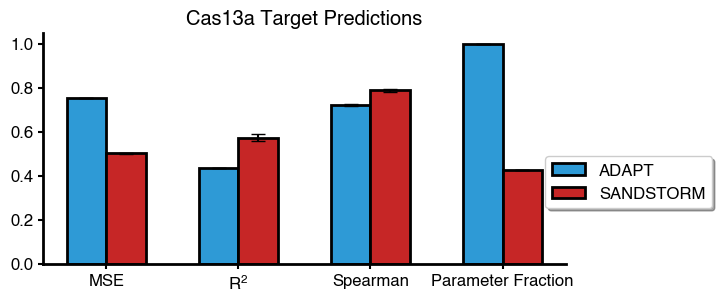

In [3]:
import matplotlib
# mse, r2_on, r2_off, spearman_on, spearman_off, parameters
joint_model_bars = [np.mean(joint_mse_save),
                    np.mean(joint_r2_save),
                    np.mean(joint_spearman_save),
                    joint_params/adapt_params]


joint_model_variances = [np.std(joint_mse_save),
                         np.std(joint_r2_save),
                         np.std(joint_spearman_save),
                        0]

adapt_bars = [np.mean(adapt_mse_save),
                    np.mean(adapt_r2_save),
                    np.mean(adapt_spearman_save),
                    adapt_params/adapt_params]

adapt_variances = [np.std(adapt_mse_save),
                         np.std(adapt_r2_save),
                         np.std(adapt_spearman_save),
                         0]

# joint_model_bars= np.load('stat_tests/joint_model_cas_metrics.npy')
# joint_model_variances = np.load('stat_tests/joint_model_cas_variances.npy')

# adapt_bars = np.load('stat_tests/adapt_metrics.npy')
# adapt_variances=np.load('stat_tests/adapt_variances.npy')

barwidth = 0.3
RED = '#C62626'
BLUE = '#2E9AD6'

plt.rcParams.update({'font.size': 12,'font.family':'Helvetica'})
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Helvetica'
plt.rcParams['mathtext.it'] = 'Helvetica:italic'
plt.rcParams['mathtext.bf'] = 'Helvetica:bold'
r1 = np.arange(len(joint_model_bars))
r2 = [x + barwidth for x in r1]

plt.figure(figsize=(6.75,3))
plt.title('Cas13a Target Predictions')
plt.bar(r1, adapt_bars, width = barwidth, color = BLUE, yerr=adapt_variances, capsize=5, label='ADAPT',edgecolor='black',linewidth=2)
plt.bar(r2, joint_model_bars, width = barwidth, color = RED, yerr=joint_model_variances, capsize=5, label='SANDSTORM',edgecolor='black',linewidth=2)
plt.xticks([r + (barwidth/2) for r in range(len(joint_model_bars))], ['MSE', r'R$^{\rm 2}$','Spearman','Parameter Fraction'],fontdict={'family':'Helvetica'})
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(2.0)
plt.subplot().spines['bottom'].set_linewidth(2.0)
plt.subplot().xaxis.set_tick_params(width=1.5)
plt.subplot().yaxis.set_tick_params(width=1.5)
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 0.5),
          fancybox=True, shadow=True, ncol=1)
# plt.savefig('../figures/SHERLOCK Predictor edgecolor.png',dpi=500,pad_inches=0.5,bbox_inches='tight')
# plt.savefig('../figures/SHERLOCK Predictor edgecolor.svg',transparent=True,pad_inches=0.5,bbox_inches='tight')



In [53]:
adapt_bars

[0.7535085678100586, 0.43392382688099956, 0.7202063167365912, 1.0]

In [5]:
joint_model_bars

array([0.50051842, 0.57208042, 0.7867413 , 0.424819  ])

In [4]:
import scipy
joint_model_bars
joint_model_variances

save = []
for i in range(len(joint_model_bars)-1):
    save.append(scipy.stats.ttest_ind_from_stats(joint_model_bars[i], 
                                     joint_model_variances[i], 
                                     3,
                                     adapt_bars[i],
                                     adapt_variances[i],
                                     3, equal_var=True, alternative='two-sided'))
    
save

[Ttest_indResult(statistic=-124.34797477890974, pvalue=2.5084714387401365e-08),
 Ttest_indResult(statistic=15.750683887239209, pvalue=9.492315990547379e-05),
 Ttest_indResult(statistic=19.371884833329457, pvalue=4.185888265920512e-05)]

In [55]:
np.save('stat_tests/joint_model_cas_metrics.npy',joint_model_bars)
np.save('stat_tests/joint_model_cas_variances.npy',joint_model_variances)

np.save('stat_tests/adapt_metrics.npy',adapt_bars)
np.save('stat_tests/adapt_variances.npy',adapt_variances)

In [56]:
joint_model_bars

[0.5005184213320414,
 0.5720804243830323,
 0.7867412959899465,
 0.4248189996682474]